# Teste Data Science Elo7 - Parte 2 - Sistema de Classificação de Produtos


## 2.1 Bibliotecas para importar

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt;
import matplotlib.gridspec as gridspec
%matplotlib inline

## 2.2 Preparação dos dados

Nesta sessão vamos apenas repetiro todo o procedimento de carregar, limpar e preparar os dados que já foi devidamente explicado no jupyter notebook referente à análise exploratória. Como tudo já está devidamente explicado em [01_analise_exploratoria.ipynb](01_analise_exploratoria.ipynb), esta etapa será feita sem as explicações e comentários entre os comandos.

In [3]:
from unidecode import unidecode

def clean_text(text):
    text = str(text)
    text = unidecode(text)
    text = text.lower()
    for t in ',.:;-_/\\+=()[]<>^~?!#*%':
        text = text.replace(t, ' ')
    return ' '.join(text.split())

def clean_and_separate_tags(text):
    text = clean_text(text)
    tags = [t for t in text.split() if not t.isdigit()]
    return tags

# carregando os dados
raw_data = pd.read_csv("elo7_recruitment_dataset.csv")
df = raw_data.copy()

# lidando com dados faltantes
df['order_counts'].fillna(0, inplace=True)
df['concatenated_tags'].fillna('', inplace=True)
df.dropna(inplace=True)
df.drop(['product_id','seller_id'], axis=1).describe()

# definindo novas variaveis
df['creation_date'] = pd.to_datetime(df['creation_date'])
date_today = pd.to_datetime('today')
df['number_of_days'] = [(date_today-day).days for day in df['creation_date']]

df['len_tags'] = [len(clean_text(t)) for t in df['concatenated_tags']]
df['len_title'] = [len(clean_text(t)) for t in df['title']]
df['len_query'] = [len(clean_text(t)) for t in df['query']]
df['price_per_weight'] = df['price']/(df['weight']+1)

df['order_probability'] = df['order_counts']/df['view_counts']
df = df[df['order_probability'] <= 1]

df['views_per_day'] = df['view_counts']/df['number_of_days']
df['orders_per_day'] = df['order_counts']/df['number_of_days']

df.drop(['product_id','seller_id'], axis=1).describe()

,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,number_of_days,len_tags,len_title,len_query,price_per_weight,order_probability,views_per_day,orders_per_day
count,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000,38422.000000
mean,1.491802,16.892145,84.109725,361.075191,0.780647,14.609000,546.285461,12.838998,1367.699183,45.392562,31.280126,19.922466,14.366134,0.031830,0.447807,0.010678
std,0.980284,11.589229,211.951291,1812.845573,0.413814,43.813837,1417.890272,43.288700,507.009416,47.113327,11.716516,9.339333,81.253071,0.062687,1.304102,0.036314
min,1.000000,0.000000,0.070000,0.000000,0.000000,0.000000,1.000000,0.000000,482.000000,0.000000,3.000000,1.000000,0.000034,0.000000,0.000343,0.000000
25%,1.000000,6.000000,12.760000,6.000000,1.000000,3.000000,119.000000,0.000000,1035.000000,18.000000,23.000000,13.000000,0.228834,0.000000,0.089224,0.000000
50%,1.000000,16.000000,28.520000,9.000000,1.000000,7.000000,243.000000,0.000000,1255.000000,32.000000,30.000000,19.000000,1.327889,0.000000,0.187845,0.000000
75%,2.000000,27.000000,90.000000,107.000000,1.000000,16.000000,521.000000,14.000000,1556.000000,57.000000,38.000000,25.000000,7.272601,0.042665,0.418852,0.010972
max,5.000000,38.000000,11509.380000,65009.000000,1.000000,3000.000000,45010.000000,2460.000000,4557.000000,2669.000000,60.000000,89.000000,5563.860000,1.000000,53.203310,2.318567


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, cross_val_predict

df.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,...,order_counts,category,number_of_days,len_tags,len_title,len_query,price_per_weight,order_probability,views_per_day,orders_per_day
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,...,0.0,Decoração,1993,11,22,14,0.143122,0.000000,0.122428,0.000000
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,...,0.0,Papel e Cia,1120,61,16,16,8.630000,0.000000,0.110714,0.000000
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,...,0.0,Outros,928,9,35,21,0.027277,0.000000,0.063578,0.000000
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,...,1.0,Bebê,1522,33,30,35,118.770004,0.005556,0.118265,0.000657
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,...,0.0,Decoração,1451,20,23,20,0.377579,0.000000,0.023432,0.000000


In [4]:
#X = df.drop(columns='CarInsurance')
#y = df['CarInsurance']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
#X_train = X_train.copy()
#X_test = X_test.copy()

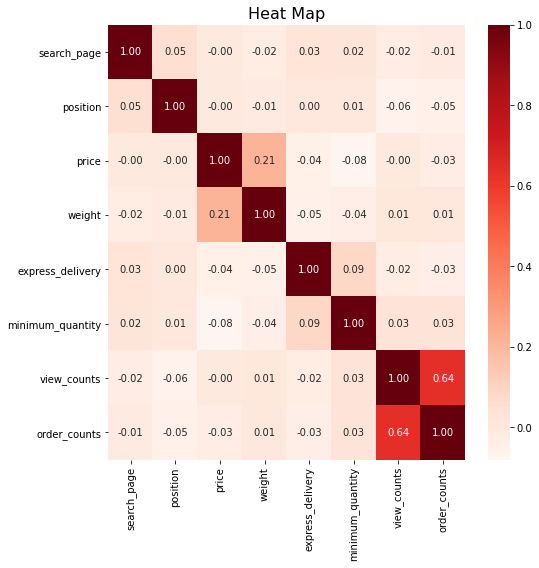

In [5]:
plt.figure(figsize=(8, 8))
sns.heatmap(raw_data.drop(['product_id','seller_id'], axis=1).corr(), annot=True, fmt='.2f', cmap='Reds')
plt.title('Heat Map', fontsize=16)
plt.show()